# Open Legal Data - Choropleth

This notebook is part of my Open Legal Data - Visualisation project, where I explore the possibilities of the Data collected through the Open Legal Data API to display Data from German courts in different ways. 

Unfortunately, GitHub does not allow uploads of files bigger than 25 MB, so I had to split the main notebook into other three. Please check [here](https://nbviewer.jupyter.org/github/celioxf/Open-Legal-Data/blob/master/Open%20Legal%20Data%20-%20Daten%20abrufen.ipynb) to see how I extracted the data and [here](https://nbviewer.jupyter.org/github/celioxf/Open-Legal-Data/blob/master/Open%20Legal%20Data%20-%20Marker%20Map.ipynb) for the interactive map I created.

# Notebook's Goal

In this notebook, we'll create a simple choropleth map to display the differences between the number of cases decided in each german state. For this we'll make use of the geopandas library to create a choropleth map of Germany.

### Importing Libraries

In [1]:
import pandas as pd
import geopandas as gpd
import googlemaps
import folium
import json
import altair as alt

### Reading The File

In [2]:
cases = pd.read_csv(r"C:\Users\celio\Data Analysis\Projects\Open Legal Data\merged.csv",
                   index_col = "Unnamed: 0")
cases.head()

id                           slug   file_number        date  \
0  328393      bgh-2020-05-07-ix-zb-5619   IX ZB 56/19  2020-05-07   
1  328192     bverwg-2020-04-22-2-b-5219     2 B 52/19  2020-04-22   
2  328242      bgh-2020-04-21-ii-zr-5618   II ZR 56/18  2020-04-21   
3  327286  bverfg-2020-03-25-2-bvr-11320  2 BvR 113/20  2020-03-25   
4  327121  bverfg-2020-03-18-1-bvr-33720  1 BvR 337/20  2020-03-18   

           created_date          updated_date                   type  \
0  2020-05-29T10:00:15Z  2020-05-29T10:07:14Z              Beschluss   
1  2020-05-21T10:00:05Z  2020-05-21T10:06:18Z              Beschluss   
2  2020-05-23T10:00:15Z  2020-05-23T10:07:16Z                 Urteil   
3  2020-04-17T10:00:22Z  2020-04-17T10:06:52Z  Nichtannahmebeschluss   
4  2020-04-09T10:00:18Z  2020-04-09T10:08:59Z  Nichtannahmebeschluss   

                                        ecli  court_id  \
0        ECLI:DE:BGH:2020:070520BIXZB56.19.0         4   
1       ECLI:DE:BVerwG:2020:220420B2B52.19.0         5   
2        ECLI:DE:BGH:2020:210420UIIZR56.18.0         4   
3  ECLI:DE:BVerfG:2020:rk20200325.2bvr011320         3   
4  ECLI:DE:BVerfG:2020:rk20200318.1bvr033720         3   

                       name  slug.1       city              state  \
0         Bundesgerichtshof     bgh  Karlsruhe  Baden-Württemberg   
1  Bundesverwaltungsgericht  bverwg    Leipzig            Sachsen   
2         Bundesgerichtshof     bgh  Karlsruhe  Baden-Württemberg   
3  Bundesverfassungsgericht  bverfg  Karlsruhe  Baden-Württemberg   
4  Bundesverfassungsgericht  bverfg  Karlsruhe  Baden-Württemberg   

                  jurisdiction level_of_appeal  
0  Ordentliche Gerichtsbarkeit   Bundesgericht  
1   Verwaltungsgerichtsbarkeit   Bundesgericht  
2  Ordentliche Gerichtsbarkeit   Bundesgericht  
3   Verfassungsgerichtsbarkeit   Bundesgericht  
4   Verfassungsgerichtsbarkeit   Bundesgericht

# Choropleth Maps

Choropleth maps are great to visualize discrepancies between geographic locations. It's composed basically of two layers, the underneath layer is the actual map and the layer over it is a json file marking the geographic shape of each location. By binding some data to the json file, it's possible to give each location a different shade, therefore indicating the frequency of a given event across multiple areas.

In [3]:
# This reads a file with the geojson coordinates from Germany.
# The Geojson works as a layer, which is placed over the tiles from the map
bd = gpd.read_file(r"C:\Users\celio\Data Analysis\Projects\Open Legal Data\bundesland.geojson")
bd.head()

sdv_rs nuts               bez       ewz       kfl  \
0  091620000000  DE2         Freistaat  12997204  70542.30   
1  150030000000  DEE              Land   2223081  20453.82   
2  051110000000  DEA              Land  17912134  34112.32   
3  040110000000  DE5  Freie Hansestadt    681032    419.41   
4  160510000000  DEG         Freistaat   2151205  16202.54   

                   gen                                           geometry  
0               Bayern  POLYGON ((10.45446 47.55574, 10.45422 47.55526...  
1       Sachsen-Anhalt  MULTIPOLYGON (((11.44677 51.19450, 11.44538 51...  
2  Nordrhein-Westfalen  MULTIPOLYGON (((6.20511 50.52197, 6.20533 50.5...  
3               Bremen  MULTIPOLYGON (((8.61640 53.19703, 8.61522 53.1...  
4            Thüringen  POLYGON ((10.78854 51.64152, 10.79005 51.64143...

The output above is a small sample of the file. To test it's integrity, we can try to plot its data.

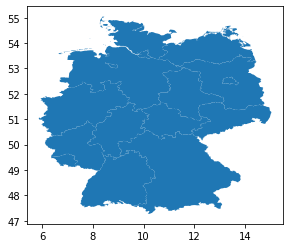

In [4]:
bd["geometry"].plot()

The geodataframe seems to be alright. We can proceed to merging it with the original DataFrame.

In [5]:
# In order to merge DataFrames, we have to make them compatible
# Since the Geopandas DataFrame has data grouped by states
# The main DataFame has to be grouped the same way
states = cases["state"].value_counts() # returns a frequency count of the state names
states = states.sort_index().reset_index()
states.columns = ["state","cases"]
states

state  cases
0        Baden-Württemberg  10705
1                   Bayern   2814
2                  Hamburg   2151
3                   Hessen   1565
4   Mecklenburg-Vorpommern   1240
5            Niedersachsen   3471
6      Nordrhein-Westfalen  14132
7          Rheinland-Pfalz   2775
8                 Saarland     29
9                  Sachsen   2547
10          Sachsen-Anhalt   2499
11      Schleswig-Holstein   1694
12               Thüringen   1855

In [6]:
# The "gen." column in the bd DataFrame has the same data of the state information in the states DF
# This means we can merge on them
# Also,merging as a left join to preserve the missing data
# Some states are not featured in the sample
geo = pd.merge(left =bd,right = states, left_on = "gen",right_on = "state",how = "left")
geo.head()

sdv_rs nuts               bez       ewz       kfl  \
0  091620000000  DE2         Freistaat  12997204  70542.30   
1  150030000000  DEE              Land   2223081  20453.82   
2  051110000000  DEA              Land  17912134  34112.32   
3  040110000000  DE5  Freie Hansestadt    681032    419.41   
4  160510000000  DEG         Freistaat   2151205  16202.54   

                   gen                                           geometry  \
0               Bayern  POLYGON ((10.45446 47.55574, 10.45422 47.55526...   
1       Sachsen-Anhalt  MULTIPOLYGON (((11.44677 51.19450, 11.44538 51...   
2  Nordrhein-Westfalen  MULTIPOLYGON (((6.20511 50.52197, 6.20533 50.5...   
3               Bremen  MULTIPOLYGON (((8.61640 53.19703, 8.61522 53.1...   
4            Thüringen  POLYGON ((10.78854 51.64152, 10.79005 51.64143...   

                 state    cases  
0               Bayern   2814.0  
1       Sachsen-Anhalt   2499.0  
2  Nordrhein-Westfalen  14132.0  
3                  NaN      NaN  
4            Thüringen   1855.0

Now we have the values we need and the coordinates all in one DataFrame, we can create a map of Germany, which offers an overview of the number of cases by state

# Map: Number of Cases by Federal State

In [7]:
# Folium takes over the organization of the map and interactivity
m = folium.Map(location = [50,10],start_zoom = 6) # We select the coordinates

# To make the difference between the states clear, we can create a choropleth map
bundeslander = folium.Choropleth(
    geo_data = geo,
    data = geo,
    columns = ["state","cases"],
    key_on = "feature.properties.gen",
    fill_color= "OrRd",
    legend_name = "Number of Cases By Federal State",
    highlight = True,
    ).add_to(m)

bundeslander.geojson.add_child(
    folium.features.GeoJsonTooltip(
        fields = ["state","cases"],
        aliases = ["Federal State","Number of Cases"]))
m

# Temporary Conclusion

As mentioned, this notebook is part of a bigger notebook I had to split because of problems during the upload to GitHub. This does not decrease the value of the map above. While it remains simple, it also shows the total number of cases in every german state. 

Next steps are:

    - Create multiple choropleth layers, in order to display one layer for each jurisdiction (this has actually been done, but the resulting file is too big for upload - so I'm trying to work around this).